# <center> Fitting the Lotka-Volterra and Replicator Models

In this notebook, the two dynamical models that we want to investigate for our study on brain cancer has been:
* Modeled
* Synthetic data has been generated
* Fitted to the generated data by:
    * solving the ODEs system to get our prediction function as a function of parameters using odeint()
    * The MSE has been minimized using lmfit.minimize()

---
### <center> Defined Needed Libraries 

In [103]:
import numpy as np 
import matplotlib.pyplot as plt
import lmfit
from scipy.integrate import odeint
from scipy import interpolate
import warnings

---
### <center> Generating the Treatment and Defining the Parameters

Define treatments matrix where each array represents a distinct treatment and each value in the array represents dose amount treatment is given on seven sessions every two days a dose is given, we take observations every two hours each observation contains: Cancer type 1, Type 2 and immune Cells population.

In [178]:
Treatment = [[0, 0, 0, 0, 0, 0, 0],
             [10**-9, 10**-9, 10**-9, 10**-9, 10**-9, 10**-9, 10**-9],
             [10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7, 10**-7],
             [10**-5, 10**-5, 10**-5, 10**-5, 10**-5, 10**-5, 10**-5],
             [10**-9, 10**-5, 10**-9, 10**-5, 10**-9, 10**-5, 10**-9],
             [0, 10**-5, 0, 10**-5, 0, 10**-5, 0]]
# we take observations every two hours each observation contains: Cancer type 1, Type 2 and immune Cells population
observations_horizon = 24  # n number of observations for each value of single treatment
treatment_full = [[c[T] for T in range(len(c)) for k in range(observations_horizon)] for c in Treatment]
x0 = [60.4551985, 56.1345208, 46.32307756]
x0_normalized = x0 / np.sum(x0)
I = 0  # Treatment number
t = np.linspace(1, len(treatment_full[0]), len(treatment_full[0]))  # time array
treatment_interpolator = interpolate.interp1d(t, treatment_full[I], fill_value="extrapolate")
num_plots = len(Treatment) # Set the number of plots to be generated
num_cols = 2  # Set the number of columns for subplots (can be adjusted as needed)
num_rows = int(np.ceil(num_plots / num_cols))
warnings.filterwarnings('ignore')

---
## <center> Lotka-Volterra Model

### Generate Lotka-Volterra Data
We generate synthetic data using the dynamical model: Lotka-Voltera with specific parameters 

In [105]:
def discrete_lotka_volterra(x0, treatment, params, show_plot:bool = True ):
    ''' 
    This function is to simulate the discrete Lotka-Volterra model with treatment
    x0: initial values of the populations
    treatment: the treatment for each time step
    params: parameters of the model
    show_plot: whether to show the plot of the simulation
    return: the populations of each type of cells
    '''
    r1, r2, r3, d12, d13, d21, d23, d31, d32, K, c1, c2, c3, m12, m13, m2, m3 = params # Parameters of the model
    i0, x10, x20 = x0 
    i1p, x1p, x2p = [], [], []
    for i in treatment:
        i_curr, x1_curr, x2_curr = i0, x10, x20    
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            x = x1_curr + x2_curr + i_curr
            f1 = i_curr / x  # frequency of immune cells
            f2 = x1_curr / x # frequency of cancer cells of type 1
            f3 = x2_curr / x # frequency of cancer cells of type 2
            di11 = i_curr * (r1 * f1 + d12 * f2 + d13 * f3) * (1 - x/K) - (c1 + c1 * 10**5 * i[k]) * i_curr - (m12 + m13) * i_curr
            dx11 = x1_curr * (d21 * f1 + r2 * f2 + d23 * f3) * (1 - x/K) - (c2 + c2 * 10**5 * i[k]) * x1_curr - m2 * x1_curr + m12 * i_curr + m3 * x2_curr
            dx22 = x2_curr * (d31 * f1 + d32 * f2 + r3 * f3) * (1 - x/K) - (c3 + c3 * 10**5 * i[k]) * x2_curr - m3 * x2_curr + m13 * i_curr + m2 * x1_curr
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
            i_curr += di11
            x1_curr += dx11
            x2_curr += dx22
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p) # append the data for each treatment
    if show_plot:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 13))
        for j in range(num_plots):
            row, col = j // num_cols, j % num_cols
            ax = axes[row, col] 
            for k, label in zip([i1p, x1p, x2p], ['immune cells i', 'U87 cells x1', 'U251 cells x2']):
                ax.plot(t, k[j], '-', label=label)
            ax.plot(t, np.array(x1p[j]) + np.array(x2p[j]), '--', label=f'tumor size')
            ax.set_xlabel('Time')
            ax.set_ylabel('Population Size')
            ax.set_title(f'Populations sizes with treatment {Treatment[j]}')
            ax.legend()
            plt.tight_layout()
        fig.suptitle("Population Size with Different Treatments Using Lotka-Volterra Model", fontsize=24, y=1.05)
        plt.show() 
    return i1p, x1p, x2p

### Example:
Generate specific data to fit our model

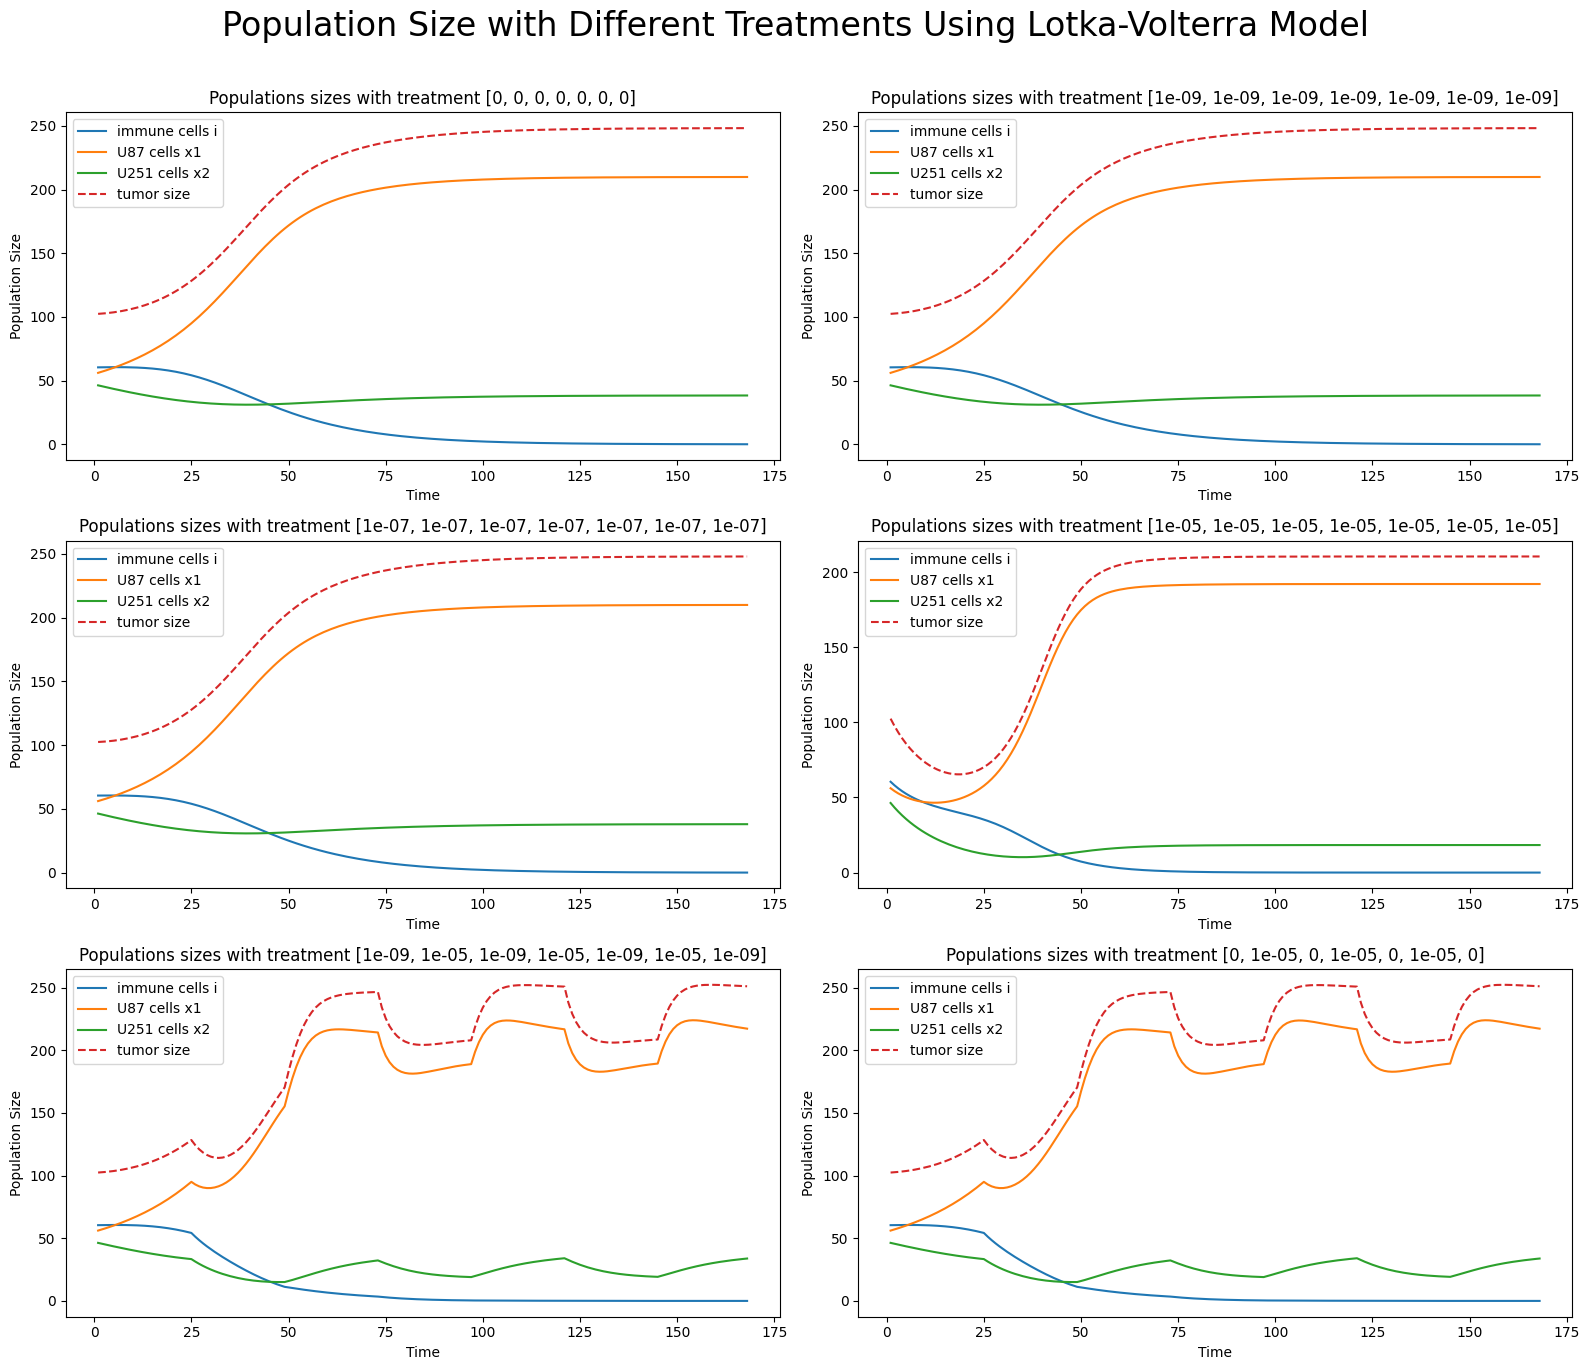

In [106]:
param_lotka_volterra = [0.3, 0.4, 0.2, 0, 0, 0, 0, 0, 0, 300, 0.04, 0.05, 0.05, 0.005, 0.005, 0.01, 0.01]
i, x1, x2 = np.array(discrete_lotka_volterra(x0, treatment_full, param_lotka_volterra, show_plot=True))

### Defining the Lotka-Voltera as system of ODEs
Defining the Lotka-Voltera dynamics to fit the parameters of dynamical model on data to be able to find the parameters used to generate synthetic data.

In [107]:
def ODEs_Lotka_Volterra(V, t , treatment_interpolator, r1, r2, r3, d12, d13, d21, d23, d31, d32, K, c1, c2, c3, m12, m13, m2, m3):
    '''
     V: vector of variables
     t: time
     treatment_interpolator: function that returns the treatment at time t 
     r1, r2, r3, d12, d13, d21, d23, d31, d32, K, c1, c2, c3, m12, m13, m2, m3: parameters
     returns: vector of derivatives
     '''
    i, x1, x2 = V 
    current_treatment = treatment_interpolator(t)
    x = x1 + x2 + i
    f1, f2, f3 = i / x, x1 / x, x2 / x
    didt = i * (r1 * f1 + d12 * f2 + d13 * f3) * (1 - x/K) - (c1 + c1 * 10**5 * current_treatment) * i - (m12 + m13) * i
    dx1dt = x1 * (d21 * f1 + r2 * f2 + d23 * f3) * (1 - x/K) - (c2 + c2 * 10**5 * current_treatment) * x1 - m2 * x1 + m12 * i + m3 * x2
    dx2dt = x2 * (d31 * f1 + d32 * f2 + r3 * f3) * (1 - x/K) - (c3 + c3 * 10**5 * current_treatment) * x2 - m3 * x2 + m13 * i + m2 * x1
    return [didt, dx1dt, dx2dt]

### Plot the Change of Rate of i, x1, x2 (didt, dx1dt, dx2dt).

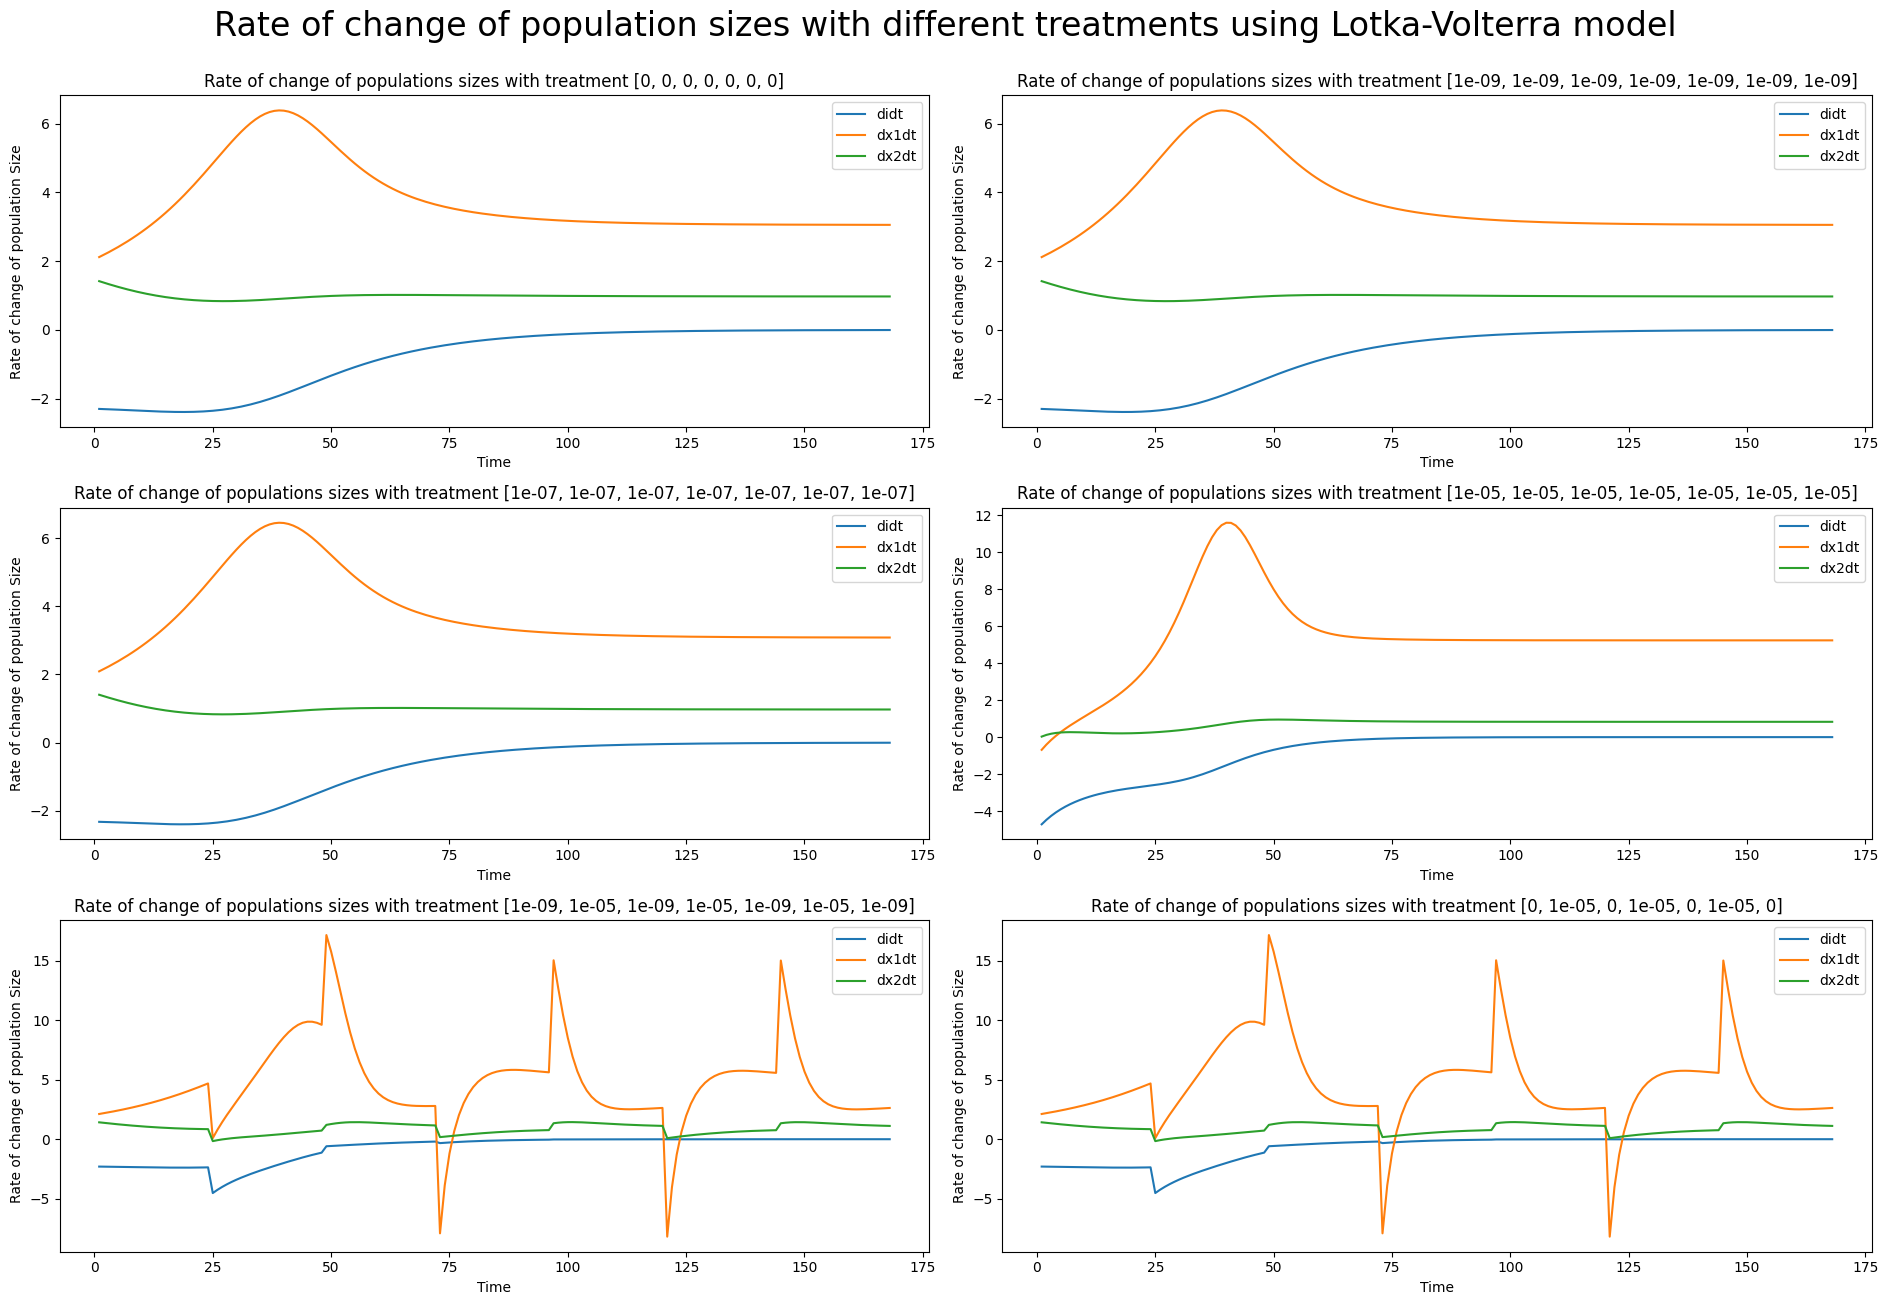

In [108]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(19, 13))
for I in range(len(Treatment)):
    V = [i[I], x1[I], x2[I]]
    treatment_interpolator = interpolate.interp1d(t, treatment_full[I], fill_value="extrapolate")
    didt, dx1dt, dx2dt = ODEs_Lotka_Volterra(V, t, treatment_interpolator, 0.1, 0.5, 0.4, 0, 0, 0, 0, 0, 0, 300, 0.04, 0.05, 0.03, 0.01, 0.005, 0.01, 0.01)
    row = I // num_cols
    col = I % num_cols    
    ax = axes[row, col]
    for k, label in zip([didt, dx1dt, dx2dt], ['didt', 'dx1dt', 'dx2dt']):
        ax.plot(t, k, '-', label=label)
    ax.set_title(f'Rate of change of populations sizes with treatment {Treatment[I]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Rate of change of population Size')
    ax.legend()
fig.suptitle("Rate of change of population sizes with different treatments using Lotka-Volterra model", fontsize=24, y=1)
plt.tight_layout()
plt.show()

In [109]:
def MSE(params, t, treatment, I, i, x1, x2): 
    ''' params: parameters to be fitted
        t: time points
        treatment: treatment values
        I: index of treatment
        i: data of i
        x1: data of x1
        x2: data of x2
        return: the MSE between the model predictions and the data '''
    p = params.valuesdict() # p: parameters
    # Solve the ODE system using odeint with the current parameter values
    X0 = np.array([i[0], x1[0], x2[0]]) 
    treatment_interpolator = interpolate.interp1d(t, treatment[I], fill_value="extrapolate") 
    sol = odeint(ODEs_Lotka_Volterra, X0, t, args= (treatment_interpolator, p['r1'], p['r2'], p['r3'], p['d12'], p['d13'], p['d21'], p['d23'], p['d31'], p['d32'], p['K'], p['c1'], p['c2'], p['c3'], p['m12'], p['m13'], p['m2'], p['m3']))
    # find the values of i, x1, x2 predicted by the model
    i_pred = sol[:,0]
    x1_pred = sol[:,1]
    x2_pred = sol[:,2]
    return np.hstack((np.mean((i_pred - i)**2), np.mean((x1_pred - x1)**2), np.mean((x2_pred - x2)**2))).ravel()


### Fit the Parameter
We want to fit the data to the previously defined ODEs function and passing treatment[I] in the arguemtns 

In [110]:
np.random.seed(42) # setting the seed for reproducibility
i_data, x1_data, x2_data = i[I], x1[I], x2[I]   # no noise 
params = lmfit.Parameters() # creating a lmfit parameters object
for k in ['r1', 'r2', 'r3', 'd12', 'd13', 'd21', 'd23', 'd31', 'd32', 'K', 'c1', 'c2', 'c3', 'm12', 'm13', 'm2', 'm3']:
    if k == 'K':
        params.add(k, value=100.0, min=100, max=300)
    else:   
        params.add(k, value=0.1, min=0, max=1)
result_lotka_volterra = lmfit.minimize(MSE, params, args=(t,treatment_full, I,  i_data, x1_data, x2_data), method='ampgo') # fitting the data
lmfit.report_fit(result_lotka_volterra) # printing the fit report

[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 127584
    # data points      = 3
    # variables        = 17
    chi-square         = 9771.86794
    reduced chi-square = 9771.86794
    Akaike info crit   = 58.2659519
    Bayesian info crit = 42.9423608
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    r1:   0.02155910 (init = 0.1)
    r2:   0.36389924 (init = 0.1)
    r3:   0.12416646 (init = 0.1)
    d12:  0.06615818 (init = 0.1)
    d13:  0.01351499 (init = 0.1)
    d21:  4.5315e-04 (init = 0.1)
    d23:  0.02381587 (init = 0.1)
    d31:  3.9553e-04 (init = 0.1)
    d32:  0.35062977 (init = 0.1)
    K:    289.166466 (init = 100)
    c1:   0.02057545 (init = 0.1)
    c2:   0.05048122 (

### Plot the Fitting Result of Lotka-Volterra


[0.021559098618990413, 0.3638992363135647, 0.12416646036601348, 0.06615817725216783, 0.013514985040815886, 0.0004531528490355208, 0.023815874331617914, 0.00039553191230418117, 0.35062977191459116, 289.16646646551544, 0.02057544853617227, 0.05048121640922948, 0.12555071687967229, 0.0026343116464889182, 0.019094888915407948, 0.008933614483927821, 0.010243761836921883]
[0.3, 0.4, 0.2, 0, 0, 0, 0, 0, 0, 300, 0.04, 0.05, 0.05, 0.005, 0.005, 0.01, 0.01]


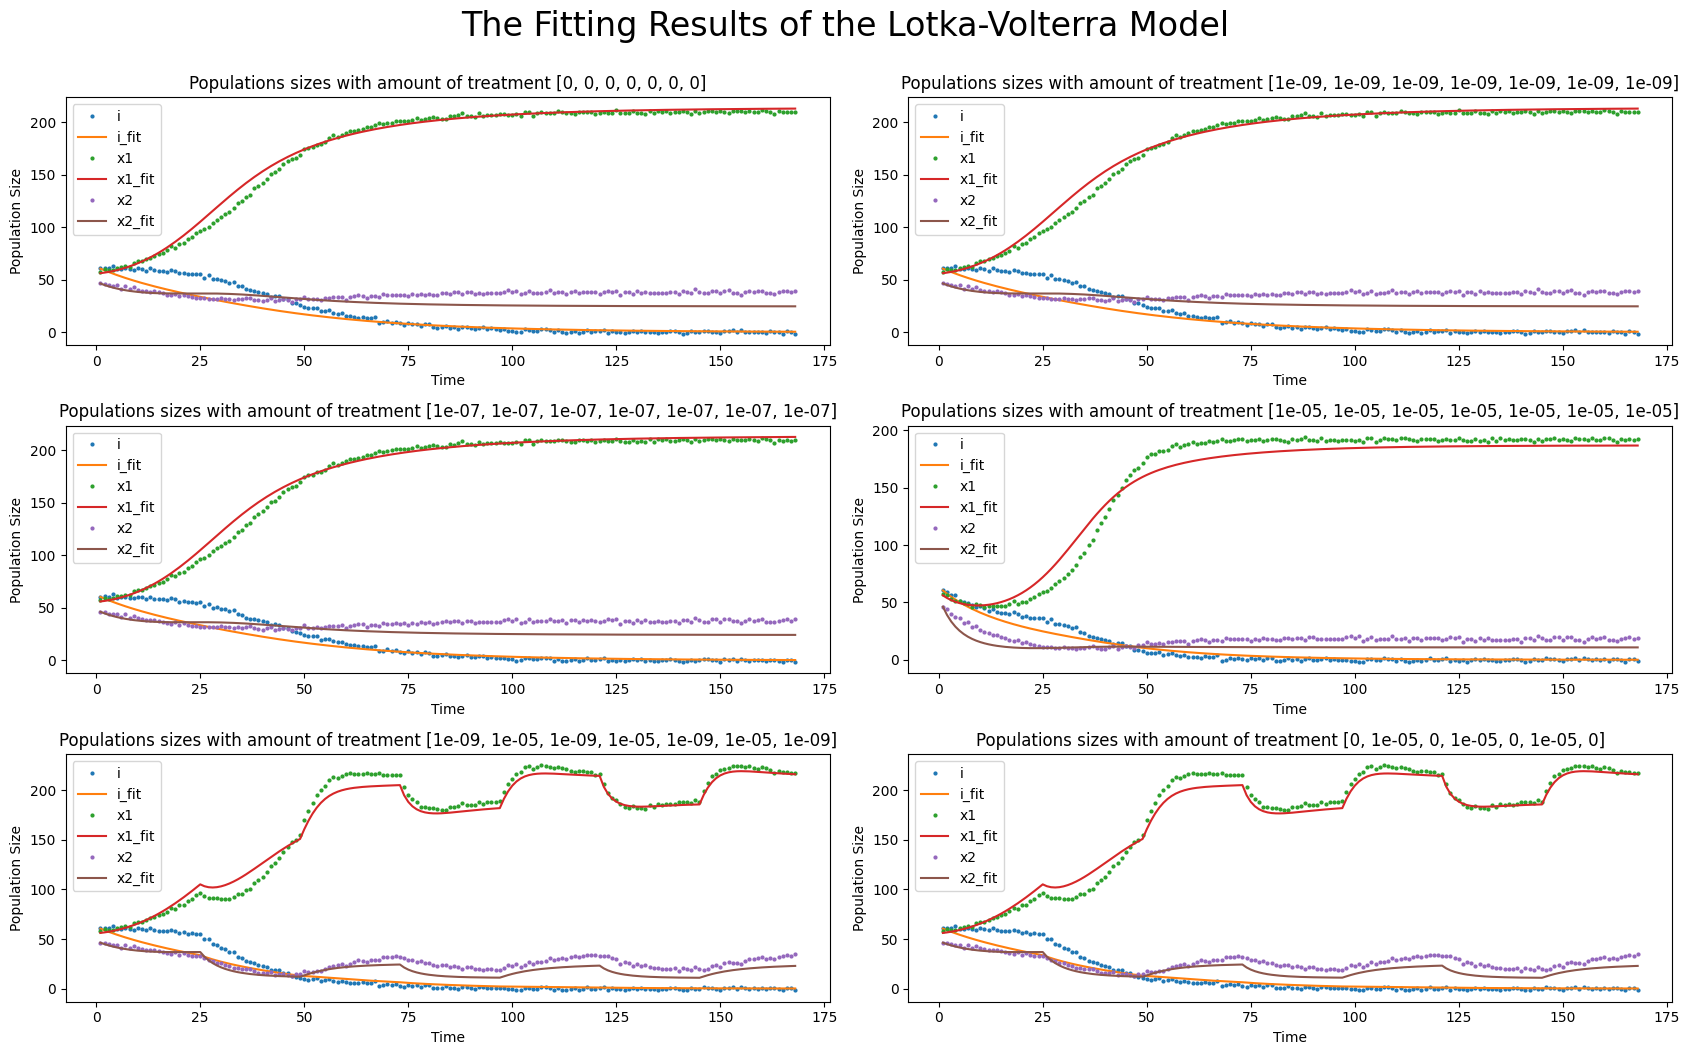

In [135]:
i, x1, x2 = np.array(discrete_lotka_volterra(x0,treatment_full, param_lotka_volterra, show_plot=False))
noise = np.random.normal(0, 1, size=(len(t), 3)) # Add noise to the data
i, x1, x2 = i + noise[:, 0], x1 + noise[:, 1], x2 + noise[:, 2] # Add noise to the data
fitted_params = list(result_lotka_volterra.params.valuesdict().values()) # Get the fitted parameters
print()
print(fitted_params)
print(param_lotka_volterra)
i_fit, x1_fit, x2_fit = np.array(discrete_lotka_volterra(x0,treatment_full, fitted_params, show_plot=False))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8.5 * num_cols, 10))
for j in range(num_plots):
    row = j // num_cols
    col = j % num_cols
    ax = axes[row, col]
    for k, label in zip([i, i_fit, x1, x1_fit, x2, x2_fit], ['i', 'i_fit', 'x1', 'x1_fit', 'x2', 'x2_fit']):
        if np.array_equal(k, i) or np.array_equal(k, x1) or np.array_equal(k, x2):
            ax.plot(t, k[j], 'o', label=label, markersize=2)
        else:
            ax.plot(t, k[j], '-', label=label)
        ax.set_xlabel('Time')
        ax.set_ylabel('Population Size')
        ax.set_title(f'Populations sizes with amount of treatment {Treatment[j]}')
        ax.legend() # Display the legend for each subplot
        plt.tight_layout() # Adjust layout to avoid overlap for each subplot
fig.suptitle("The Fitting Results of the Lotka-Volterra Model", fontsize=24, y=1.05)
plt.show() 

---
# <center> Replicator Model

In [206]:
def discrete_replicator(x0, treatment, params, show_plot:bool = True ):
    '''
    This function is used to simulate the population size of each population using replicator model
    Input:
        x0: initial population size of each population (i1, x1, x2), it should be normalized
        treatment: the treatment used in the experiment
        params: the parameters of the model
        show_plot: whether to show the plot of the population size
    Output:
        i1p: the population size of immune cells
        x1p: the population size of U87 cells
        x2p: the population size of U251 cells
    '''
    r1, r2, r3, d12, d13, d21, d23, d31, d32, k11, k12, k13, k21, k22, k23, k31, k32, k33 = params # Parameters of the model
    i1p, x1p, x2p = [], [], []
    for i in treatment:  # create data based on each treatment 
        i_curr, x1_curr, x2_curr = x0    
        i11p, x11p, x22p = [], [], []
        for k in range(len(i)):
            # Define the average fitness of each population
            phi = i_curr**2 * (r1 - k11 * 10**5 * i[k]) + i_curr * x1_curr * (d12 - 10**5 * k11 * i[k]) 
            + i_curr * x2_curr * (d13 - 10**5 * k13 * i[k]) + i_curr * x1_curr * (d21 - 10**5 * k21 * i[k]) 
            + x1_curr**2 * (r2 - 10**5 * k22 * i[k]) + x1_curr * x2_curr * (d23 - 10**5 * k23 * i[k]) 
            + i_curr * x2_curr * (d31 - 10**5 * k31 * i[k]) + x1_curr * x2_curr * (d32 - 10**5 * k32 * i[k]) + x2_curr**2 * (r3 - 10**5 * k33 * i[k]) 
            di11 = i_curr * (i_curr * (r1 - 10**5 * k11 * i[k]) + x1_curr * (d12 - 10**5 * k12 * i[k]) + x2_curr * (d13 - 10**5 * k13 * i[k]) - phi)
            dx11 = x1_curr * (i_curr * (d21 - 10**5 * k21 * i[k]) + x1_curr * (r2 - 10**5 * k22 * i[k]) + x2_curr * (d23 - 10**5 * k23 * i[k]) - phi)
            dx22 = x2_curr * (i_curr * (d31 - 10**5 * k31 * i[k]) + x1_curr * (d32 - 10**5 * k32 * i[k]) + x2_curr * (r3 - 10**5 * k33 * i[k]) - phi)
            i_curr += di11 
            x1_curr += dx11
            x2_curr += dx22
            sum = i_curr + x1_curr + x2_curr
            i_curr /= sum 
            x1_curr /= sum
            x2_curr /= sum
            i11p.append(i_curr), x11p.append(x1_curr), x22p.append(x2_curr)
        i1p.append(i11p), x1p.append(x11p), x2p.append(x22p) # append the data for each treatment
    if show_plot:
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 10))
        for j in range(num_plots):
            row = j // num_cols
            col = j % num_cols
            ax = axes[row, col]  
            for k, label in zip([i1p, x1p, x2p], ['immune cells i', 'U87 cells x1', 'U251 cells x2']):
                ax.plot(t, k[j], '-', label= label)
            ax.plot(t, np.array(x1p[j]) + np.array(x2p[j]), '--', label=f'size of tumor x1+x2')
            ax.set_xlabel('Time')
            ax.set_ylabel('Population Size')
            ax.set_title(f'Populations sizes with treatment {Treatment[j]}')
            ax.legend() 
            plt.tight_layout()
        fig.suptitle("population sizes with different treatments using Replicator model", fontsize=24, y=1.05)
        plt.show() 
    return i1p, x1p, x2p

### Example

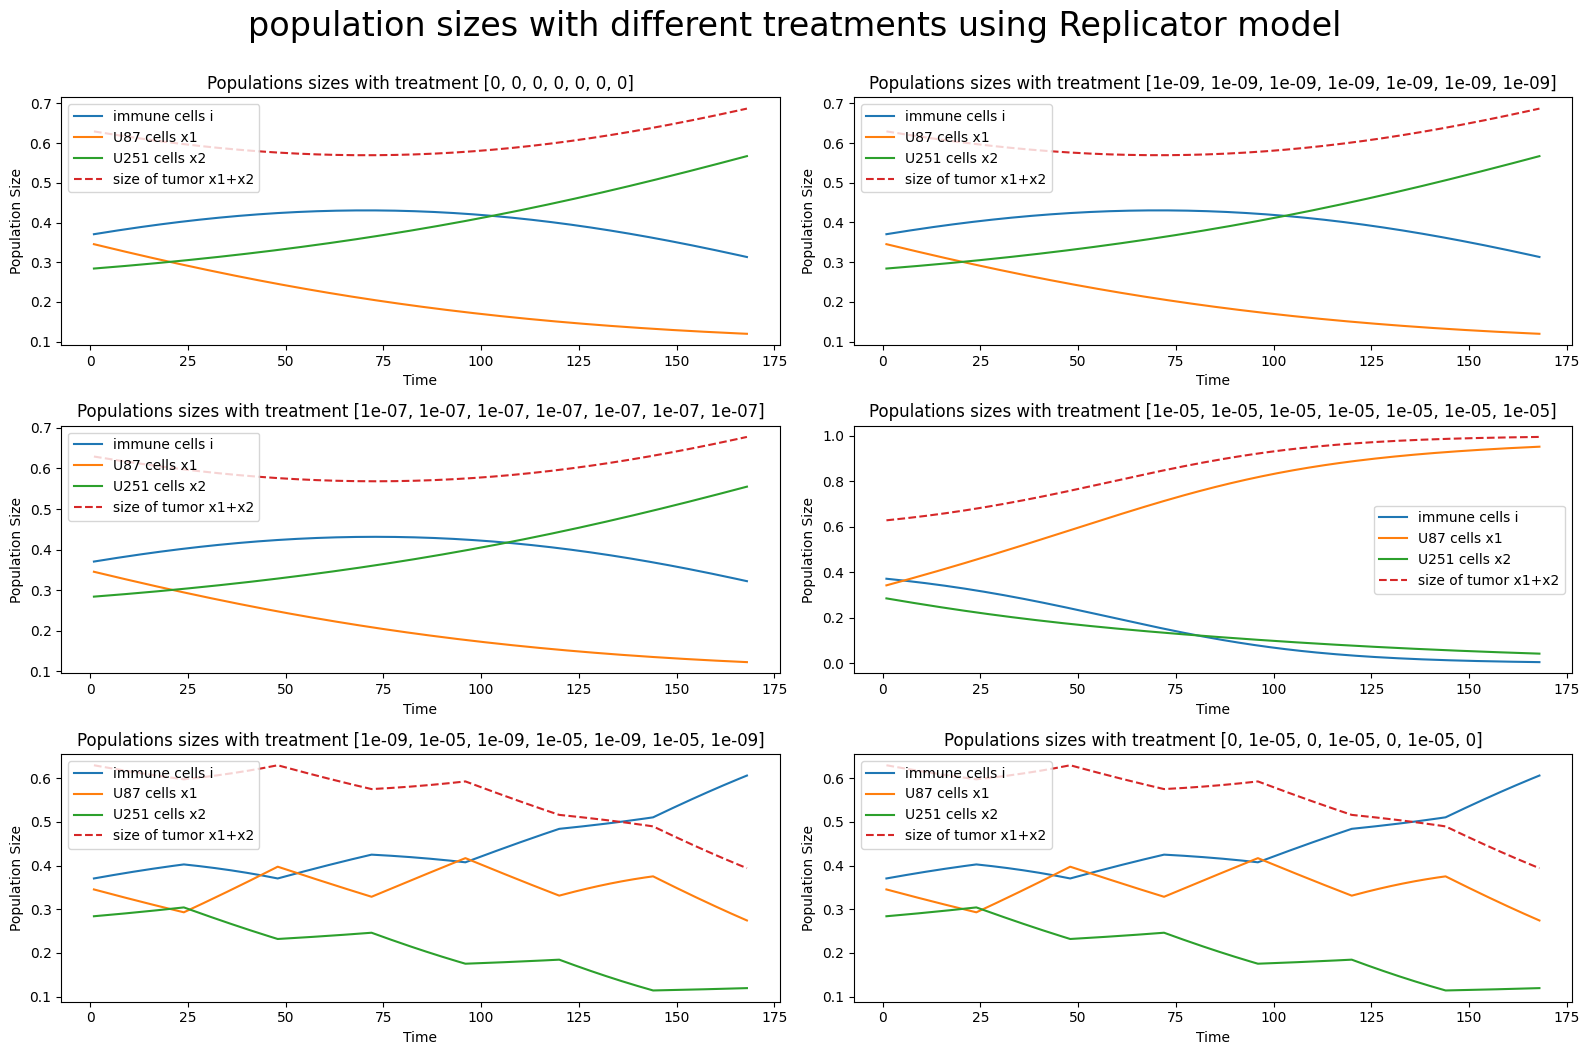

In [207]:
param_replicator = np.array([0.098, 0.013, 0.069, 0.04, 0.042, 0.071, 0.069, 0.099,  0.012, 0.01, 0.072, 0.057, 0.027, 0.007, 0.008, 0.089, 0.019, 0.032])
i, x1, x2 = np.array(discrete_replicator(x0,treatment_full, param_replicator, show_plot=True))

### Defining the Replicator Model as System of ODEs
Defining the Replicator dynamics to fit the parameters of dynamical model on data to be able to find the parameters used to generate synthetic data.

In [150]:
def ODEs_replicator(V, t , treatment_interpolator, r1, r2, r3, d12, d13, d21, d23, d31, d32, k11, k12, k13, k21, k22, k23, k31, k32, k33):
    '''
    Differential equations for the replicator dynamics, with the treatment as a function of time.
    V: vector of the population frequencies (i, x1, x2) should be normalized.
    '''
    i, x1, x2 = V 
    current_treatment = treatment_interpolator(t)  # treatment at current time
    # avereg fitness of the population
    phi = i**2 * (r1 - 10**5 * k11 * current_treatment) + i * x1 * (d12 - 10**5 * k11 * current_treatment) + i * x2 * (d13 - 10**5 * k13 * current_treatment) 
    + i * x1 * (d21 - 10**5 * k21 * current_treatment) + x1**2 * (r2 - 10**5 * k22 * current_treatment) + x1 * x2 * (d23 - 10**5 * k23 * current_treatment) 
    + i * x2 * (d31 - 10**5 * k31 * current_treatment) + x1 * x2 * (d32 - 10**5 * k32 * current_treatment) + x2**2 * (r3 - 10**5 * k33 * current_treatment) 
    didt = i * (i * (r1 - 10**5 * k11 * current_treatment) + x1 * (d12 - 10**5 * k12 * current_treatment) + x2 * (d13 - 10**5 * k13 * current_treatment) - phi)
    dx1dt = x1 * (i * (d21 - 10**5 * k21 * current_treatment) + x1 * (r2 - 10**5 * k22 * current_treatment) + x2 * (d23 - 10**5 * k23 * current_treatment) - phi)
    dx2dt = x2 * (i * (d31 - 10**5 * k31 * current_treatment) + x1 * (d32 - 10**5 * k32 * current_treatment) + x2 * (r3 - 10**5 * k33 * current_treatment) - phi)
    return [didt, dx1dt, dx2dt]

### Plot the Change of Rate of i, x1, x2 (didt, dx1dt, dx2dt).

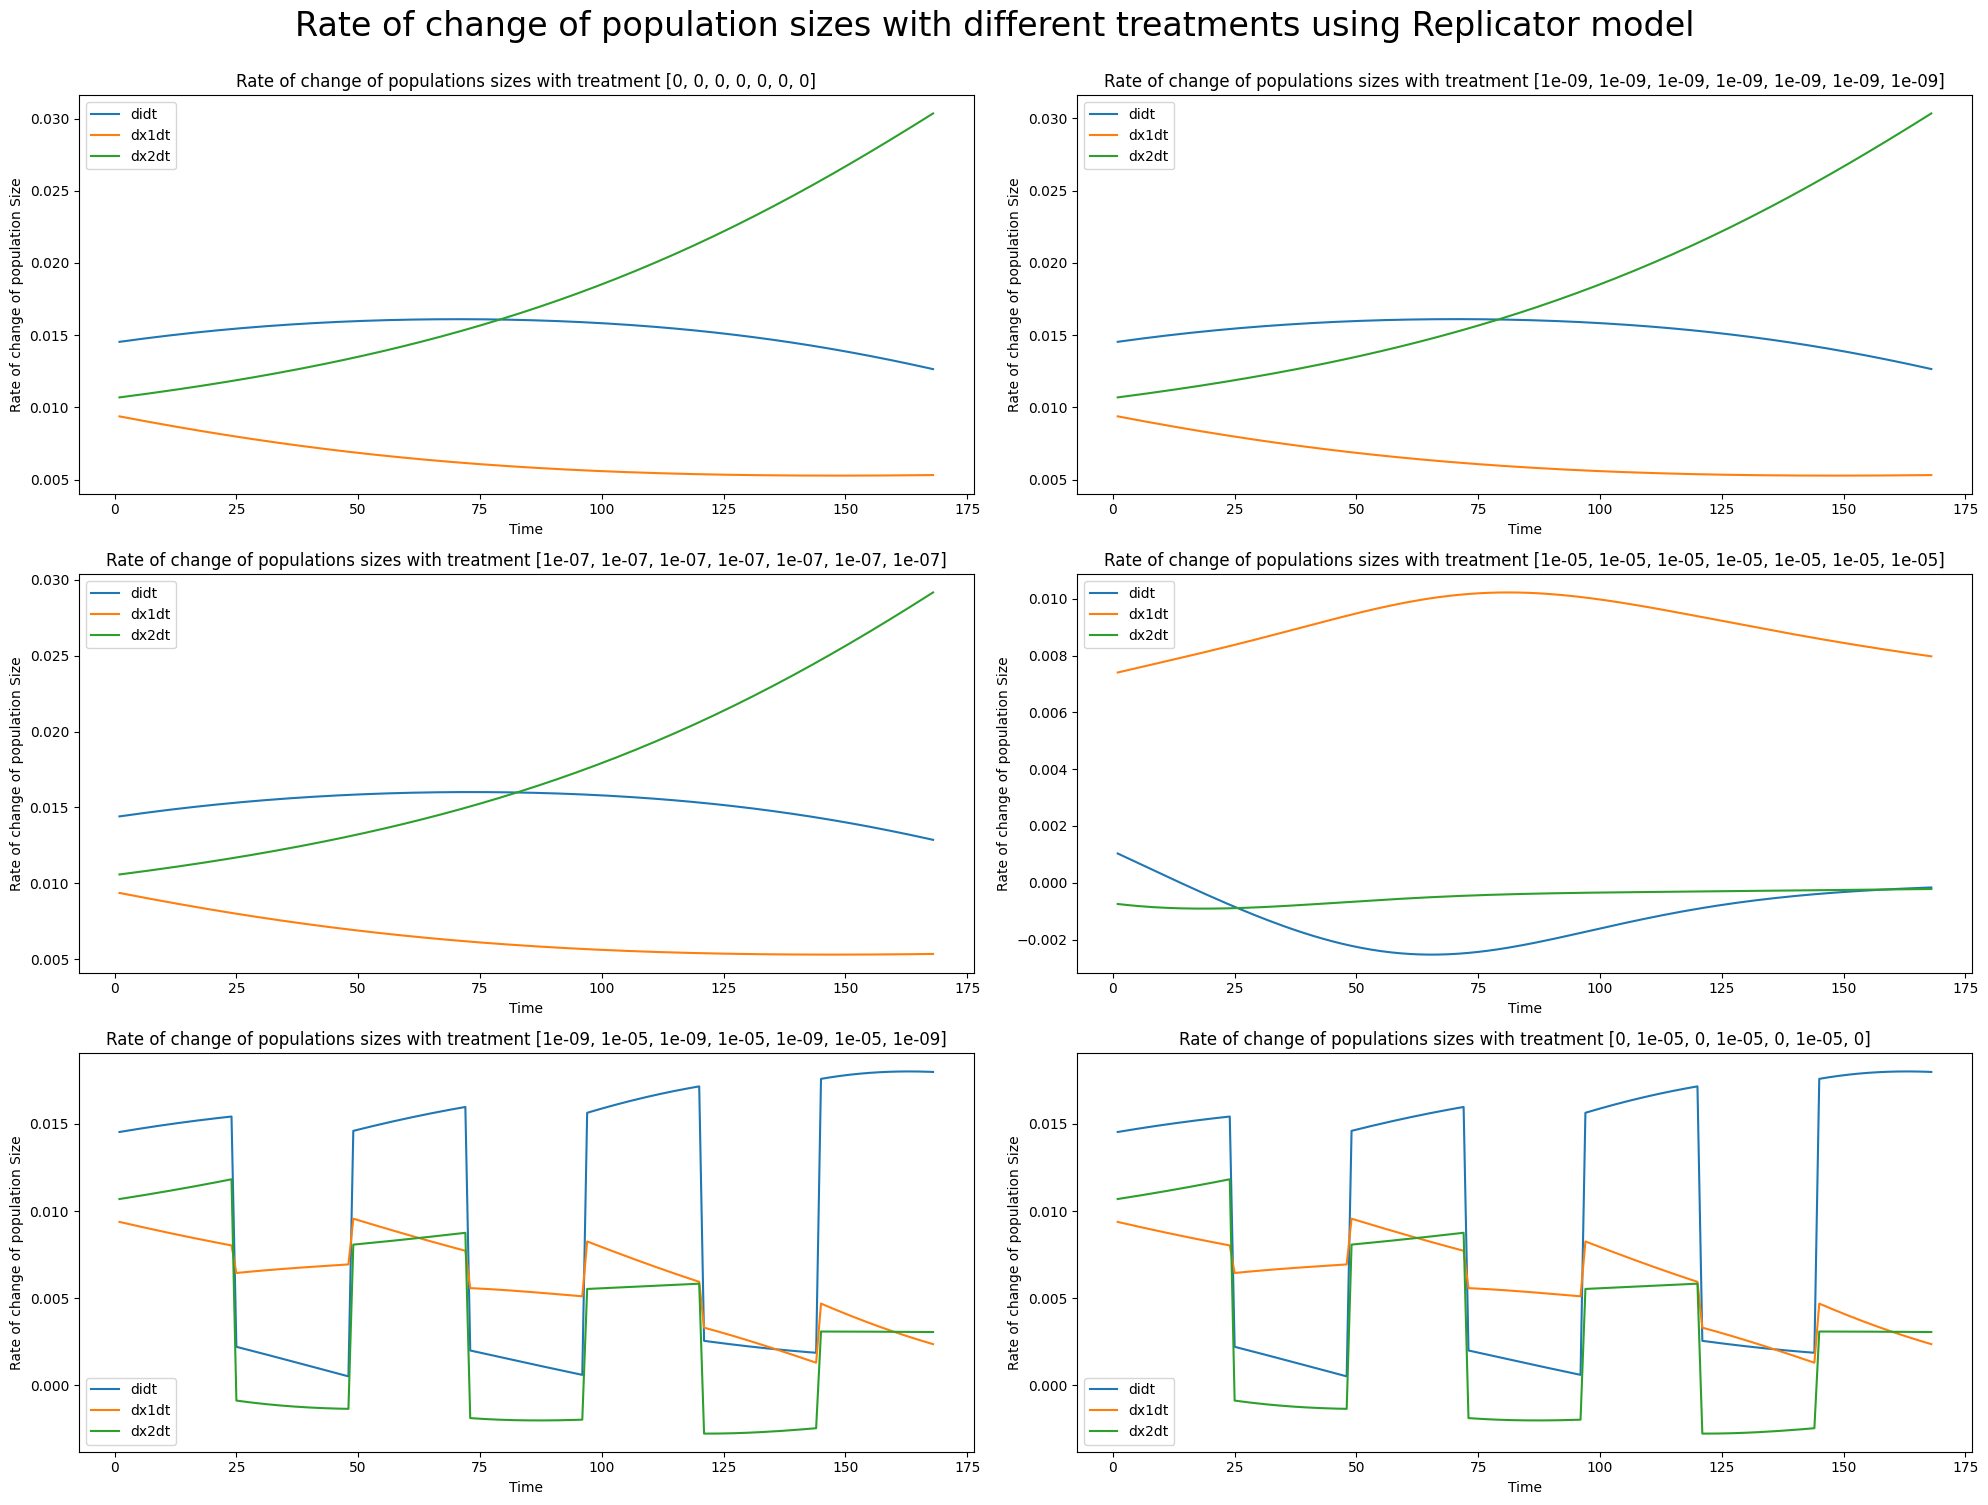

In [151]:
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 15))
for I in range(len(Treatment)):
    V = [i[I], x1[I], x2[I]]
    treatment_interpolator = interpolate.interp1d(t, treatment_full[I], fill_value="extrapolate")
    didt, dx1dt, dx2dt = ODEs_replicator(V, t, treatment_interpolator, 0.098, 0.013, 0.069, 0.04, 0.042, 0.071, 0.069, 0.099,  0.012, 0.01, 0.072, 0.057, 0.027, 0.007, 0.008, 0.089, 0.019, 0.032)   
    row = I // num_cols
    col = I % num_cols    
    ax = axes[row, col]  
    for k, label in zip([didt, dx1dt, dx2dt], ['didt', 'dx1dt', 'dx2dt']):
        ax.plot(t, k, '-', label=label)
    ax.set_title(f'Rate of change of populations sizes with treatment {Treatment[I]}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Rate of change of population Size')
    ax.legend() 
fig.suptitle("Rate of change of population sizes with different treatments using Replicator model", fontsize=24, y=1)
plt.tight_layout()
plt.show()

### Define Mean Square Error MSE

In [152]:
def MSE(params, t, treatment, I, i, x1, x2): 
    ''' 
    mean squared error (MSE) between the model and the data
    params: parameters to be fitted
    t: time points
    treatment: treatment values
    I: indices of treatment values
    i: data of i
    x1: data of x1
    x2: data of x2
    return: MSE between the model and the data
    '''
    p = params.valuesdict() 
    X0 = np.array([i[0], x1[0], x2[0]]) 
    treatment_interpolator = interpolate.interp1d(t, treatment[I], fill_value="extrapolate") 
    sol = odeint(ODEs_replicator, X0, t, args= (treatment_interpolator, p['r1'], p['r2'], p['r3'], p['d12'], p['d13'], p['d21'], p['d23'], p['d31'], p['d32'], p['k11'], p['k12'], p['k13'], p['k21'], p['k22'], p['k23'], p['k31'], p['k32'], p['k33']))
    i_pred, x1_pred, x2_pred = sol[:,0], sol[:,1], sol[:,2] 
    return np.hstack((np.mean((i_pred - i)**2), np.mean((x1_pred - x1)**2), np.mean((x2_pred - x2)**2))).ravel()

### Fit the Parameter
We want to fit the data to the previously defined ODEs function and passing treatment[I] in the arguemtns 

In [160]:
np.random.seed(42) 
I = 1
i_data, x1_data, x2_data = i[I], x1[I], x2[I]   # no noise 
params = lmfit.Parameters() # creating a lmfit parameters object
for k in ['r1', 'r2', 'r3', 'd12', 'd13', 'd21', 'd23', 'd31', 'd32', 'k11', 'k12', 'k13', 'k21', 'k22', 'k23', 'k31', 'k32', 'k33']:
    params.add(k, value=0, min=0, max=0.1)
result_replicator = lmfit.minimize(MSE, params, args=(t,treatment_full, I,  i_data, x1_data, x2_data), method='ampgo')
lmfit.report_fit(result_replicator) 

[[Fit Statistics]]
    # fitting method   = ampgo, with L-BFGS-B as local solver
    # function evals   = 30894
    # data points      = 3
    # variables        = 18
    chi-square         = 2.2228e+40
    reduced chi-square = 2.2228e+40
    Akaike info crit   = 311.410650
    Bayesian info crit = 295.185671
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    r1:   0.07842894 (init = 0)
    r2:   0.04211142 (init = 0)
    r3:   0.05076937 (init = 0)
    d12:  0.03911573 (init = 0)
    d13:  0.01921244 (init = 0)
    d21:  0.03959840 (init = 0)
    d23:  0.09572118 (init = 0)
    d31:  0.04260196 (init = 0)
    d32:  0.05610592 (init = 0)
    k11:  0.06591761 (init = 0)
    k12:  0.04359807 (init = 0)
    k13:  0.07066858 (init = 0)
    k21:  0.0

### Plot the Fitting Result

Real Parameters: [0.098 0.013 0.069 0.04  0.042 0.071 0.069 0.099 0.012 0.01  0.072 0.057
 0.027 0.007 0.008 0.089 0.019 0.032]
Fitted parameters: [0.07842893979065797, 0.042111417579344966, 0.05076936577796113, 0.03911572619736361, 0.019212439587065835, 0.039598404628191156, 0.09572118264677609, 0.04260196302995547, 0.0561059237692487, 0.06591760845879083, 0.04359806881867283, 0.07066857806121817, 0.05892087722438928, 0.09981134209063297, 0.0413439768856293, 0.07656834845513937, 0.08361964786010766, 0.07742824767818761]


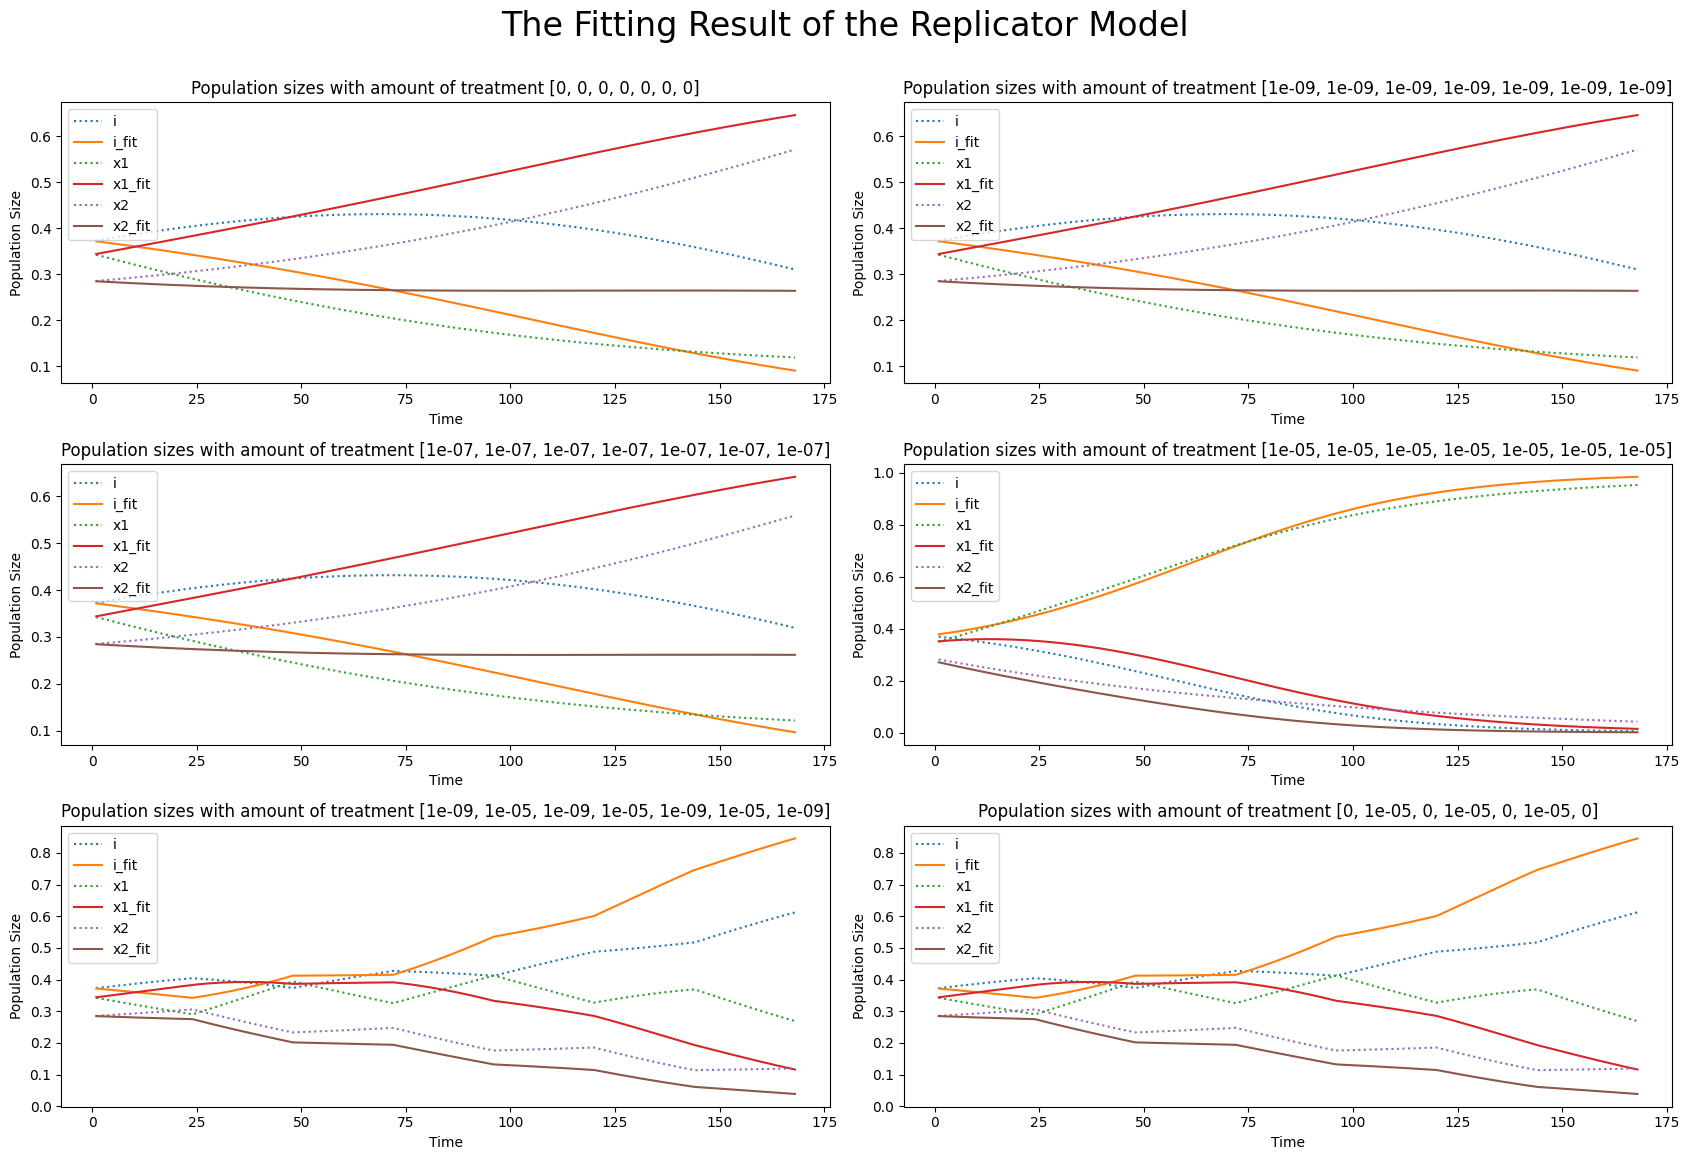

In [208]:
i, x1, x2 = np.array(discrete_replicator(x0_normalized, treatment_full, param_replicator, show_plot=False))
noise = np.random.normal(0, 0.01, size=(len(t), 3))
#i, x1, x2 = i + noise[:, 0], x1 + noise[:, 1], x2 + noise[:, 2]
fitted_params_replicator = list(result_replicator.params.valuesdict().values())
print('Real Parameters:', param_replicator)
print('Fitted parameters:', fitted_params_replicator)
i_fit, x1_fit, x2_fit = np.array(discrete_replicator(x0,treatment_full, fitted_params_replicator, show_plot=False))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8.5 * num_cols, 11))
for j in range(num_plots):
    row = j // num_cols
    col = j % num_cols
    ax = axes[row, col]
    for k, label in zip([i, i_fit, x1, x1_fit, x2, x2_fit], ['i', 'i_fit', 'x1', 'x1_fit', 'x2', 'x2_fit']):
        if np.array_equal(k, i) or np.array_equal(k, x1) or np.array_equal(k, x2):
            ax.plot(t, k[j], ':', label=label)
        else:
            ax.plot(t, k[j], '-', label=label)
        ax.set_xlabel('Time')
        ax.set_ylabel('Population Size')
        ax.set_title(f'Population sizes with amount of treatment {Treatment[j]}')
        ax.legend() 
        plt.tight_layout() 
fig.suptitle("The Fitting Result of the Replicator Model", fontsize=24, y=1.05)
plt.show() 

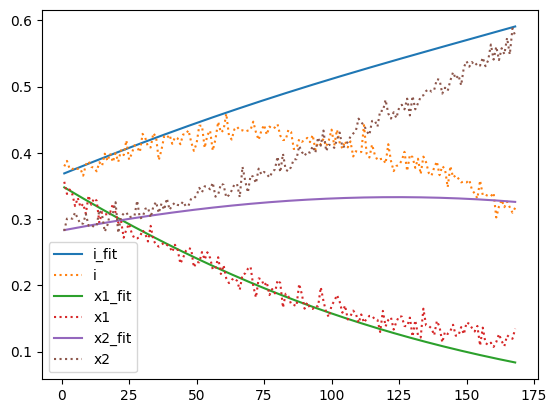

In [ ]:
i_fit, x1_fit, x2_fit = np.array(discrete_replicator(x0,treatment_full, fitted_params_replicator, show_plot=False))
# plot the results
plt.plot(t, i_fit[0], label='i_fit')
plt.plot(t, i[0], ':', label='i')
plt.plot(t, x1_fit[0], label='x1_fit')
plt.plot(t, x1[0], ':', label='x1')
plt.plot(t, x2_fit[0], label='x2_fit')
plt.plot(t, x2[0], ':', label='x2')
plt.legend()
plt.show()
